In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from epiweeks import Week 
from matplotlib import cm 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

sys.path.append('../')
from bayes_ensemble.bayes_ensemble import Scorer
from utils import load_preds, dates_23, dates_24

# Definir a cor das bordas (spines) como cinza
mpl.rcParams['axes.edgecolor'] = 'gray'

# Definir a cor das linhas dos ticks maiores e menores como cinza
mpl.rcParams['xtick.color'] = 'gray'
mpl.rcParams['ytick.color'] = 'gray'
mpl.rcParams['xtick.labelcolor'] = 'black'
mpl.rcParams['ytick.labelcolor'] = 'black'
plt.rcParams['axes.labelsize'] = 14  # Axis labels
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['font.size'] = 14  # General font size

In [2]:
UNIQUE_MODELS = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'E1', 'E2']

In [3]:
df_preds, models_by_state, data_all = load_preds(exclude = False)
df_ens_base = pd.read_csv(f'../predictions/ensemble_2023_2024_E1_mandatory.csv')
df_ens_base['model_id'] = 'E1'
df_ens_base.date = pd.to_datetime(df_ens_base.date)
df_preds = pd.concat([df_preds, df_ens_base], ignore_index = True)
df_preds['model_id'] = df_preds['model_id'].replace({'ln_crps': 'E2'})
df_preds = df_preds.loc[df_preds.model_id.isin(UNIQUE_MODELS)]
df_preds.head()

,date,pred,lower,upper,state,model_id
0,2022-10-09,110.690113,64.291013,219.826948,AC,M1
1,2025-08-10,192.641953,142.814506,261.828157,PR,M1
2,2025-08-17,171.137457,119.943438,233.918928,PR,M1
3,2025-08-24,196.875395,132.696765,267.461459,PR,M1
4,2025-08-31,179.610112,136.303073,247.230651,PR,M1


In [4]:
states = ['AM', 'CE', 'GO', 'MG', 'PR']
#models = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7']
models = ['E1', 'E2']
flag = 'ensemble'

In [5]:
def get_scorer(state, model, df_preds, data_all, year):

    if year == 2023:
        dates_ = dates_23

    if year == 2024:
        dates_ = dates_24
 
    metrics = {}
    
    df_preds_ = df_preds.loc[df_preds.date.isin(dates_)]
    p1 = df_preds_.loc[(df_preds_.state == state) & (df_preds_.model_id == model)][['date', 'lower', 'pred', 'upper']].reset_index(drop = True)
    data_all_ = data_all.loc[data_all.date.isin(dates_)]
    d1 = data_all_.loc[data_all_.uf == state][['date','casos']]

    score = Scorer(df_true =d1, pred = p1)

    metrics['crps'] = score.crps[1]
    metrics['log_score'] = score.log_score[1]
    metrics['interval_score'] = score.interval_score[1]

    df1 = pd.DataFrame([metrics])
    
    df1['state'] = state
    df1['model'] = model

    return df1


In [6]:
%%time 
df_metrics_23 = pd.DataFrame()
df_metrics_24 = pd.DataFrame()

for s in states:
    for m in models: 

        df_metrics_23 = pd.concat([df_metrics_23, get_scorer(s, m, df_preds, data_all, 2023)], ignore_index = True)
        df_metrics_24 = pd.concat([df_metrics_24, get_scorer(s, m, df_preds, data_all, 2024)], ignore_index = True)

CPU times: user 4.67 s, sys: 9.7 ms, total: 4.68 s
Wall time: 4.71 s


In [7]:
df_23 = df_metrics_23.pivot(columns = 'state', index = 'model', values = 'crps')

df_23.head(7)

state,AM,CE,GO,MG,PR
model,,,,,
E1,46.147466,485.184116,924.839278,2249.829953,1671.286278
E2,27.633726,351.347980,761.079179,1791.273363,1248.918683


In [8]:
df_24 = df_metrics_24.pivot(columns = 'state', index = 'model', values = 'crps')

df_24.head()

state,AM,CE,GO,MG,PR
model,,,,,
E1,65.973343,286.912042,5018.110828,33766.358092,9595.144994
E2,75.805470,124.036725,5609.722616,33452.778543,5934.942912


In [9]:
def plot_heat(ax, df, year, metric, label): 

    df_ = df.pivot(columns = 'state', index = 'model', values = metric)

    if metric == 'log_score':
        palette = 'Reds_r'
    else: 
        palette = 'Reds'

    sns.heatmap(df_, annot=True, fmt='.0f',  cmap=palette, cbar_kws={'label': metric}, ax = ax)

    ax.set_xlabel('State')
    ax.set_ylabel('Model')
    ax.tick_params(axis='y', labelrotation=0)  
    ax.set_title(f'{label} - {year}')
    
def apply_colormap(data, colormaps):
    rows, cols = data.shape
    colored_data = np.zeros((rows, cols, 3))  # Store RGB values

    for i in range(cols):
        norm = plt.Normalize(vmin=data[:, i].min(), vmax=data[:, i].max())  # Normalize per column
        cmap = cm.get_cmap(colormaps[i])
        colored_data[:, i, :] = cmap(norm(data[:, i]))[:, :3]  # Apply colormap, exclude alpha
    return colored_data
    
def plot_heat2(ax, df, year, metric, label):

    if metric == 'log_score':
        colormaps = ['Reds', 'Reds', 'Reds', 'Reds', 'Reds']
    else:
        colormaps = ['Reds_r', 'Reds_r', 'Reds_r', 'Reds_r', 'Reds_r']

    df_ = df.pivot(columns = 'state', index = 'model', values = metric)

    df_ = df_.values
    # Apply colormap
    colored_data = apply_colormap(df_, colormaps)

    # Plot heatmap
    ax.imshow(colored_data, aspect='auto')  # Show the colored matrix

    # Add text labels (data values) to each cell
    rows, cols = df_.shape
    for i in range(rows):
        for j in range(cols):

            r, g, b = colored_data[i, j]
        
            # Compute luminance (perceived brightness)
            luminance = 0.299 * r + 0.587 * g + 0.114 * b
        
            # Choose white or black text based on brightness
            text_color = 'black' if luminance > 0.5 else 'white'
        
            # Add text
            ax.text(j, i, f"{df_[i, j]:.2f}", ha='center', va='center', 
                color=text_color, fontsize=12)
        
            #ax.text(j, i, f"{df_[i, j]:.2f}", ha='center', va='center', color='white', fontsize=12, fontweight='bold')

    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(['AM', 'CE', 'GO', 'MG', 'PR'])
    ax.set_yticks(np.arange(2))
    ax.set_yticklabels(['E1', 'E2'])
    ax.set_frame_on(False)  # Hide the border
    ax.set_xlabel('State')
    ax.set_ylabel('Model')
    ax.tick_params(axis='y', labelrotation=0)  
    ax.set_title(f'{label} - {year}')

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_31508/211867345.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[i])
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_31508/211867345.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[i])


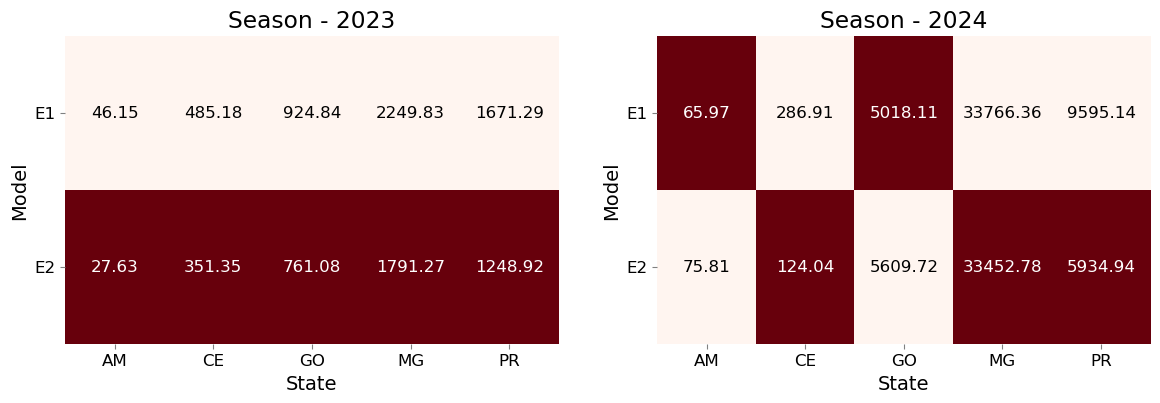

In [10]:
_,ax = plt.subplots(1,2, figsize=(14, 4))

plot_heat2(ax[0], df_metrics_23, 2023, metric = 'crps', label = 'Season')
plot_heat2(ax[1], df_metrics_24, 2024, metric = 'crps', label = 'Season')

plt.savefig(f'../figures/crps_season_{flag}.pdf', bbox_inches = 'tight')

plt.show()

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_31508/211867345.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[i])
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_31508/211867345.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[i])


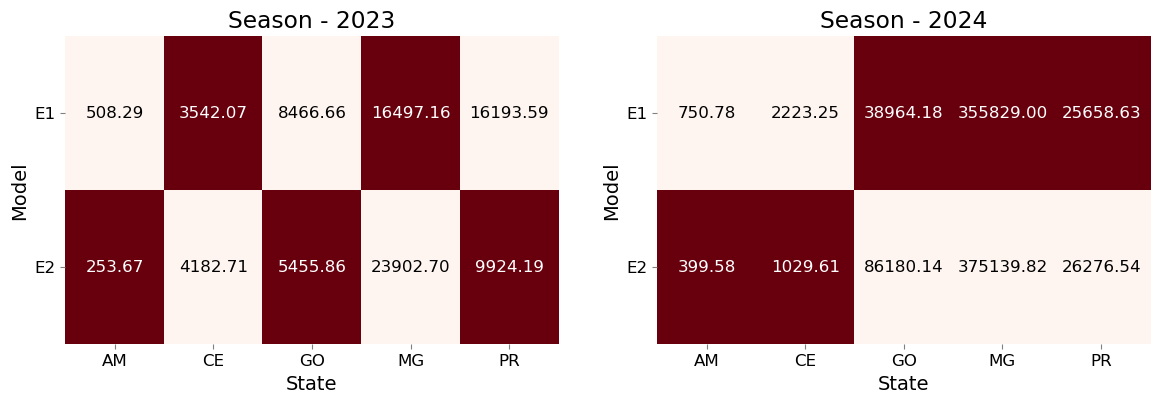

In [11]:
_,ax = plt.subplots(1,2, figsize=(14, 4))

plot_heat2(ax[0], df_metrics_23, 2023, metric = 'interval_score', label = 'Season')
plot_heat2(ax[1], df_metrics_24, 2024, metric = 'interval_score', label = 'Season')

plt.savefig(f'../figures/interval_score_season_{flag}.pdf', bbox_inches = 'tight')

plt.show()

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_31508/211867345.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[i])
/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_31508/211867345.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormaps[i])


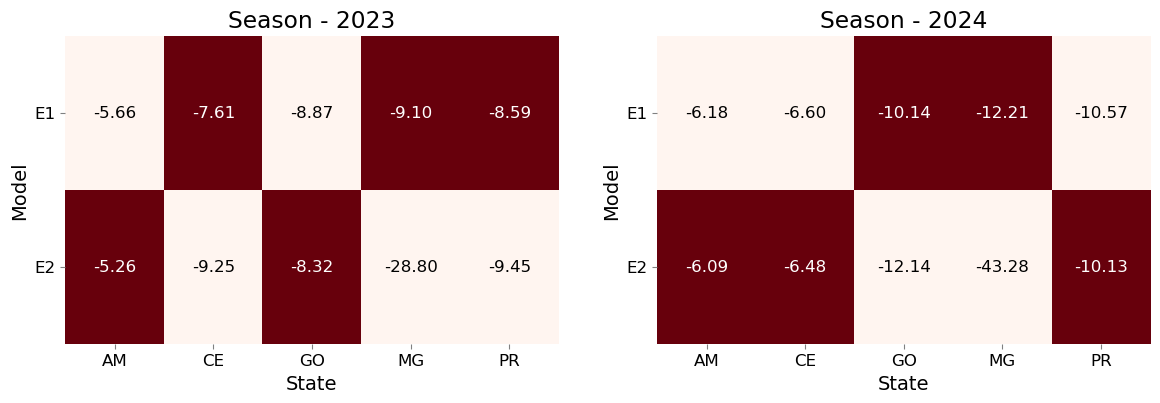

In [12]:
_,ax = plt.subplots(1,2, figsize=(14, 4))

plot_heat2(ax[0], df_metrics_23, 2023, metric = 'log_score', label = 'Season')
plot_heat2(ax[1], df_metrics_24, 2024, metric = 'log_score', label = 'Season')

plt.savefig(f'../figures/log_score_season_{flag}.pdf', bbox_inches = 'tight')

plt.show()

### Compute scores daily:

In [13]:
data_23 = data_all.loc[(data_all.date >= Week(2022, 41).startdate().strftime('%Y-%m-%d')) & (data_all.date <= Week(2023, 40).startdate().strftime('%Y-%m-%d'))] 
data_24 = data_all.loc[(data_all.date >= Week(2023, 41).startdate().strftime('%Y-%m-%d')) & (data_all.date <= Week(2024, 40).startdate().strftime('%Y-%m-%d'))] 

peak_dates = {'AM':{2023: {}, 2024: {}}, 'CE': {2023: {}, 2024: {}}, 'GO':{2023: {}, 2024: {}}, 'PR':{2023: {}, 2024: {}}, 'MG':{2023: {}, 2024: {}}}

for state in ['AM', 'CE', 'GO', 'PR', 'MG']:
    
    df_23 = data_23.loc[data_23.uf == state]
    
    peak_date = pd.to_datetime(df_23.loc[df_23.casos == df_23['casos'].max()].date.values[0])

    peak_dates[state][2023]['peak_date'] = peak_date

    df_24 = data_24.loc[data_24.uf == state]
    
    peak_date = pd.to_datetime(df_24.loc[df_24.casos == df_24['casos'].max()].date.values[0])

    peak_dates[state][2024]['peak_date'] = peak_date

In [14]:
def get_score_daily(state, model, df_preds, data_all, year):

    if year == 2023:
        dates_ = dates_23
        start = Week(2022, 41).startdate().strftime('%Y-%m-%d')
        end = Week(2023, 14).startdate().strftime('%Y-%m-%d')

    if year == 2024:
        dates_ = dates_24
        start = Week(2023, 41).startdate().strftime('%Y-%m-%d')
        end = Week(2024, 14).startdate().strftime('%Y-%m-%d')
    
    df_preds_ = df_preds.loc[df_preds.date.isin(dates_)]
    p1 = df_preds_.loc[(df_preds_.state == state) & (df_preds_.model_id == model)][['date', 'lower', 'pred', 'upper']].reset_index(drop = True)

    data_all_ = data_all.loc[data_all.date.isin(dates_)]
    d1 = data_all_.loc[data_all_.uf == state][['date','casos']]

    score = Scorer(df_true =d1, pred = p1)

    metrics_crps = pd.DataFrame(score.crps[0], columns = ['crps'])
    metrics_log = pd.DataFrame(score.log_score[0], columns = ['log_score'])
    metrics_int = pd.DataFrame(score.interval_score[0], columns = ['interval_score'])

    metrics = pd.concat([metrics_crps, metrics_log, metrics_int], axis = 1)

    metrics['state'] = state
    metrics['model'] = model
    metrics['date'] = dates_

    return metrics

In [15]:
df_dm_23 = pd.DataFrame()
df_dm_24 = pd.DataFrame()

for s in states:
    for m in models: 

        df_dm_23 = pd.concat([df_dm_23, get_score_daily(s, m, df_preds, data_all, 2023)])
        df_dm_24 = pd.concat([df_dm_24, get_score_daily(s, m, df_preds, data_all, 2024)])

In [16]:
df_dm_23.head()

,crps,log_score,interval_score,state,model,date
0,154.341665,-8.012715,866.720319,AM,E1,2022-10-09
1,111.249629,-7.459110,201.919971,AM,E1,2022-10-16
2,69.887431,-6.718784,217.855238,AM,E1,2022-10-23
3,62.579615,-6.607566,217.273882,AM,E1,2022-10-30
4,44.142226,-6.199370,242.043973,AM,E1,2022-11-06


In [17]:
UNIQUE_MODELS = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'E1', 'E2']
# Define colors manually, mapping each region to a color from tab10
colors = plt.get_cmap('Set2').colors[:len(UNIQUE_MODELS)]
COLOR_MAP = dict(zip(UNIQUE_MODELS, colors))
colors_  =  plt.get_cmap('tab10').colors
COLOR_MAP['M6'] = plt.get_cmap('Set2').colors[7]
COLOR_MAP['E1'] = colors[5]
COLOR_MAP['E2'] = colors_[3]

In [18]:
COLOR_MAP

{'M1': (0.4, 0.7607843137254902, 0.6470588235294118),
 'M2': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'M3': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'M4': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 'M5': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 'M6': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 'M7': (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 'E1': (1.0, 0.8509803921568627, 0.1843137254901961),
 'E2': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)}

In [19]:
def plot_metric(ax, state, metric):

    if metric == 'crps':
        label = 'CRPS'
    if metric == 'log_score':
        label = 'Logarithmic score'
    if metric == 'interval_score':
        label = 'Interval score'


    pd = peak_dates[state][2023]['peak_date']
    ax[0].axvline(pd, color = 'black', ls = '--', linewidth = 1.5, label = 'peak date')

    sns.lineplot(ax=ax[0], data = df_dm_23.loc[df_dm_23.state == state].reset_index(), x = 'date', y = metric,
             hue = 'model', palette = COLOR_MAP, linewidth = 1.5, legend = False)

    pd = peak_dates[state][2024]['peak_date']
    ax[1].axvline(pd, color = 'black', ls = '--', linewidth = 1.5, label = 'peak date')

    sns.lineplot(ax=ax[1], data = df_dm_24.loc[df_dm_24.state == state].reset_index(), x = 'date', y = metric,
                 hue = 'model', palette = COLOR_MAP, linewidth = 1.5)
    
    ax[1].legend(title = 'Model')

    ax[0].set_title(f'{label} - {state} - 2023')

    ax[1].set_title(f'{label} - {state} - 2024')

    for ax_ in ax: 
        ax_.grid()
        ax_.set_ylabel(label)



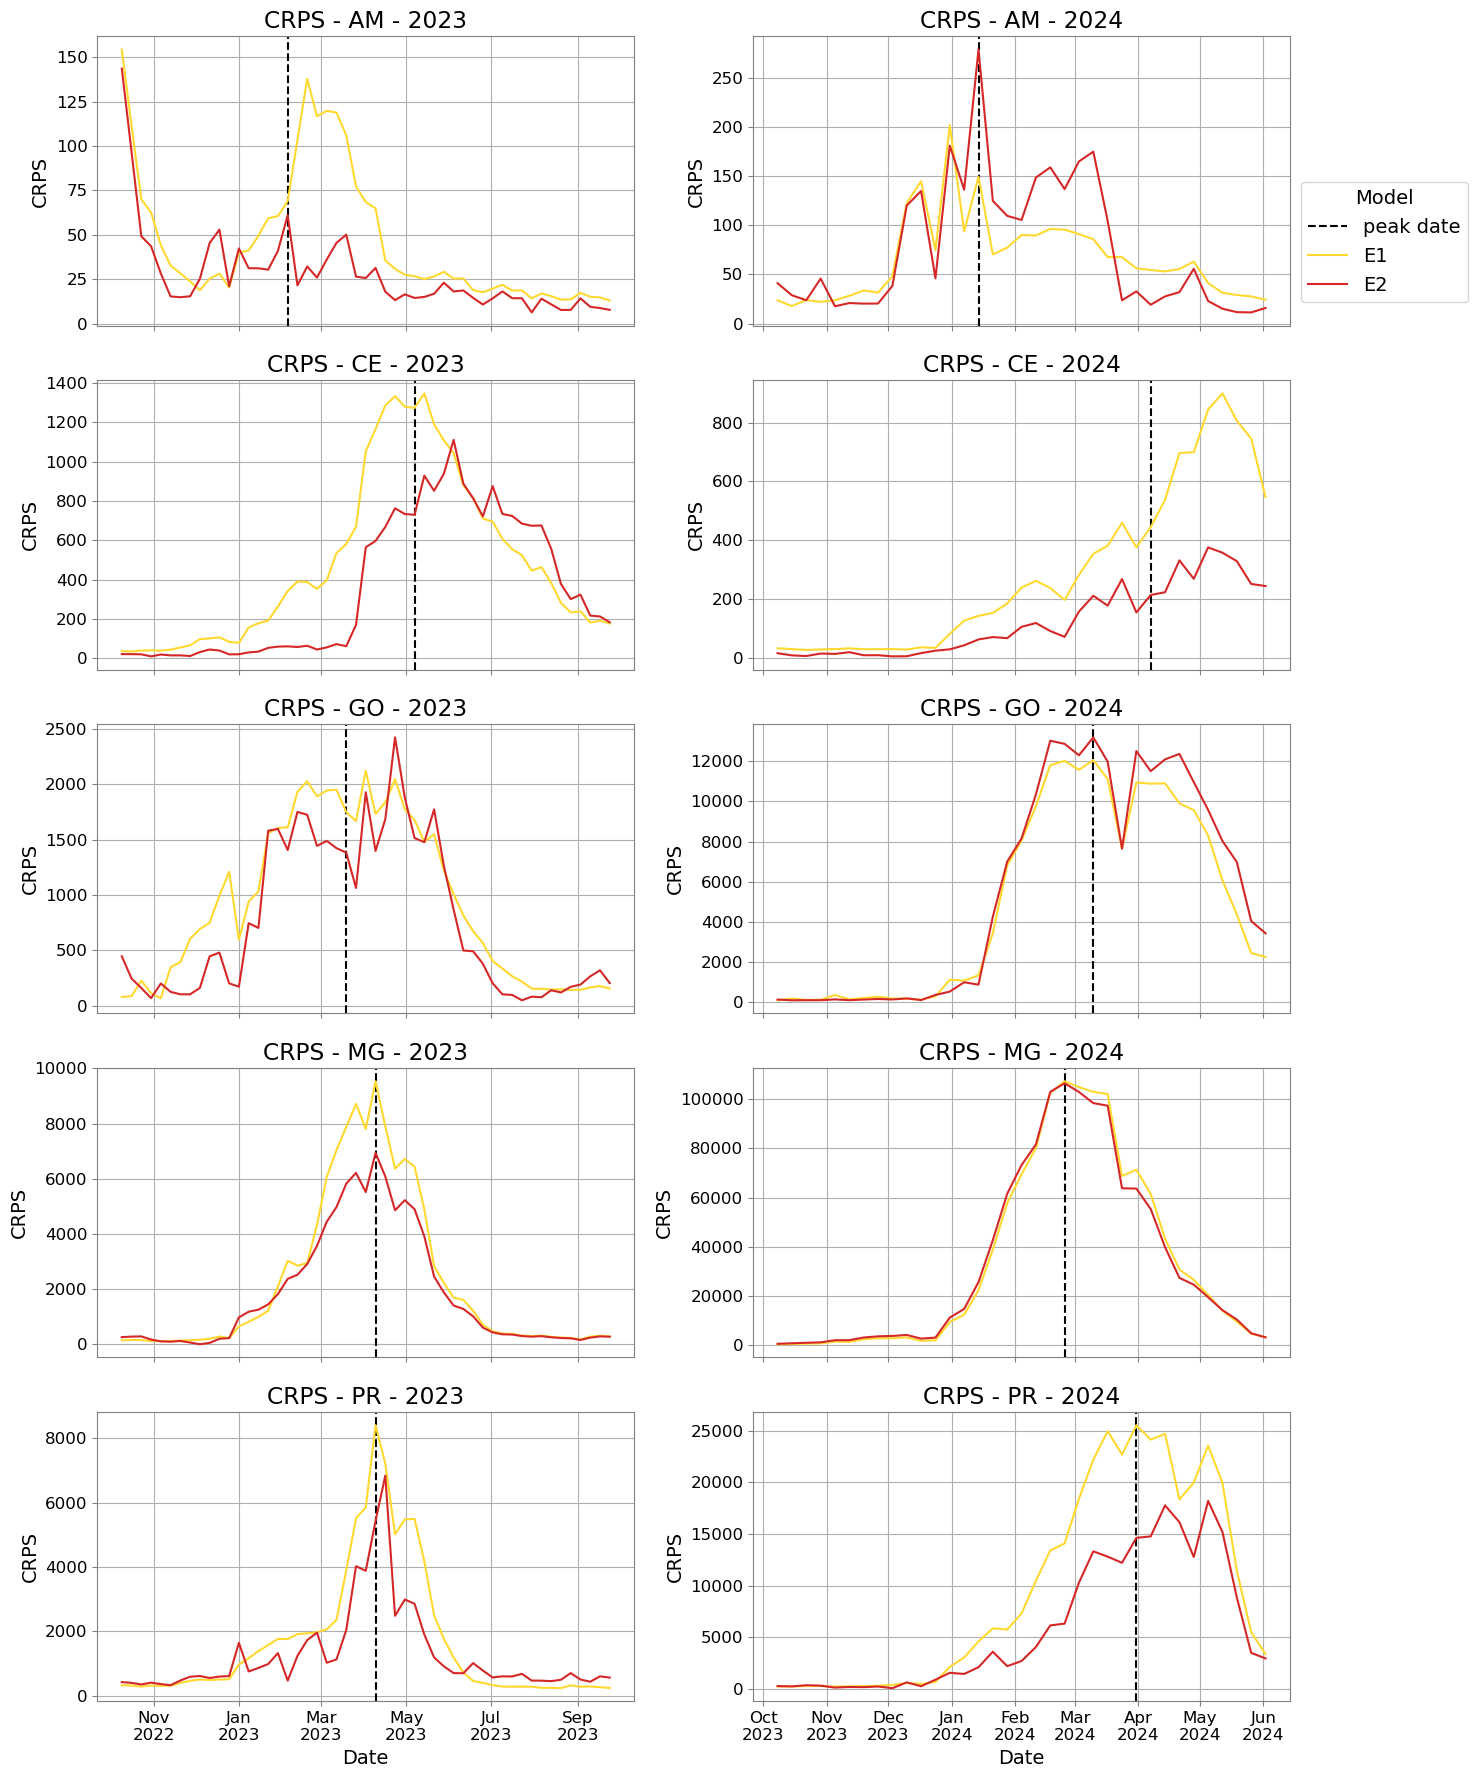

In [20]:
_,ax = plt.subplots(5,2, figsize = (15,18))

metric = 'crps'
plot_metric([ax[0,0], ax[0,1]], 'AM', metric)
plot_metric([ax[1,0], ax[1,1]], 'CE', metric)
plot_metric([ax[2,0], ax[2,1]], 'GO', metric)
plot_metric([ax[3,0], ax[3,1]], 'MG', metric)
plot_metric([ax[4,0], ax[4,1]], 'PR', metric)

for ax_ in ax.ravel()[:-2]:
    ax_.set_xticklabels([])
    ax_.set_xlabel('')

for ax_ in [ax[1,1], ax[2,1], ax[3,1], ax[4,1]]:
    ax_.get_legend().remove() 
    
for ax_ in [ax[4,0], ax[4,1]]: 
    ax_.set_xlabel('Date')
    ax_.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax[0,1].legend(title = 'Model', loc = (1.02, 0.08))

plt.savefig(f'../figures/curve_{metric}_{flag}.pdf', dpi = 450, bbox_inches = 'tight')

#plt.subplots_adjust(wspace = -0.25, hspace = -0.25)

plt.tight_layout()
plt.show()

In [21]:
def plot_metric_all_state(metric):
    
    _,ax = plt.subplots(5,2, figsize = (15,18))
    
    plot_metric([ax[0,0], ax[0,1]], 'AM', metric)
    plot_metric([ax[1,0], ax[1,1]], 'CE', metric)
    plot_metric([ax[2,0], ax[2,1]], 'GO', metric)
    plot_metric([ax[3,0], ax[3,1]], 'MG', metric)
    plot_metric([ax[4,0], ax[4,1]], 'PR', metric)
    
    for ax_ in ax.ravel()[:-2]:
        ax_.set_xticklabels([])
        ax_.set_xlabel('')
    
    for ax_ in [ax[1,1], ax[2,1], ax[3,1], ax[4,1]]:
        ax_.get_legend().remove() 
        
    for ax_ in [ax[4,0], ax[4,1]]: 
        ax_.set_xlabel('Date')
        ax_.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    

    ax[0,1].legend(title = 'Model', loc = (1.02, 0.08))

    plt.tight_layout()
    
    plt.savefig(f'../figures/curve_{metric}_{flag}.pdf', dpi = 450, bbox_inches = 'tight')
    
    plt.show()

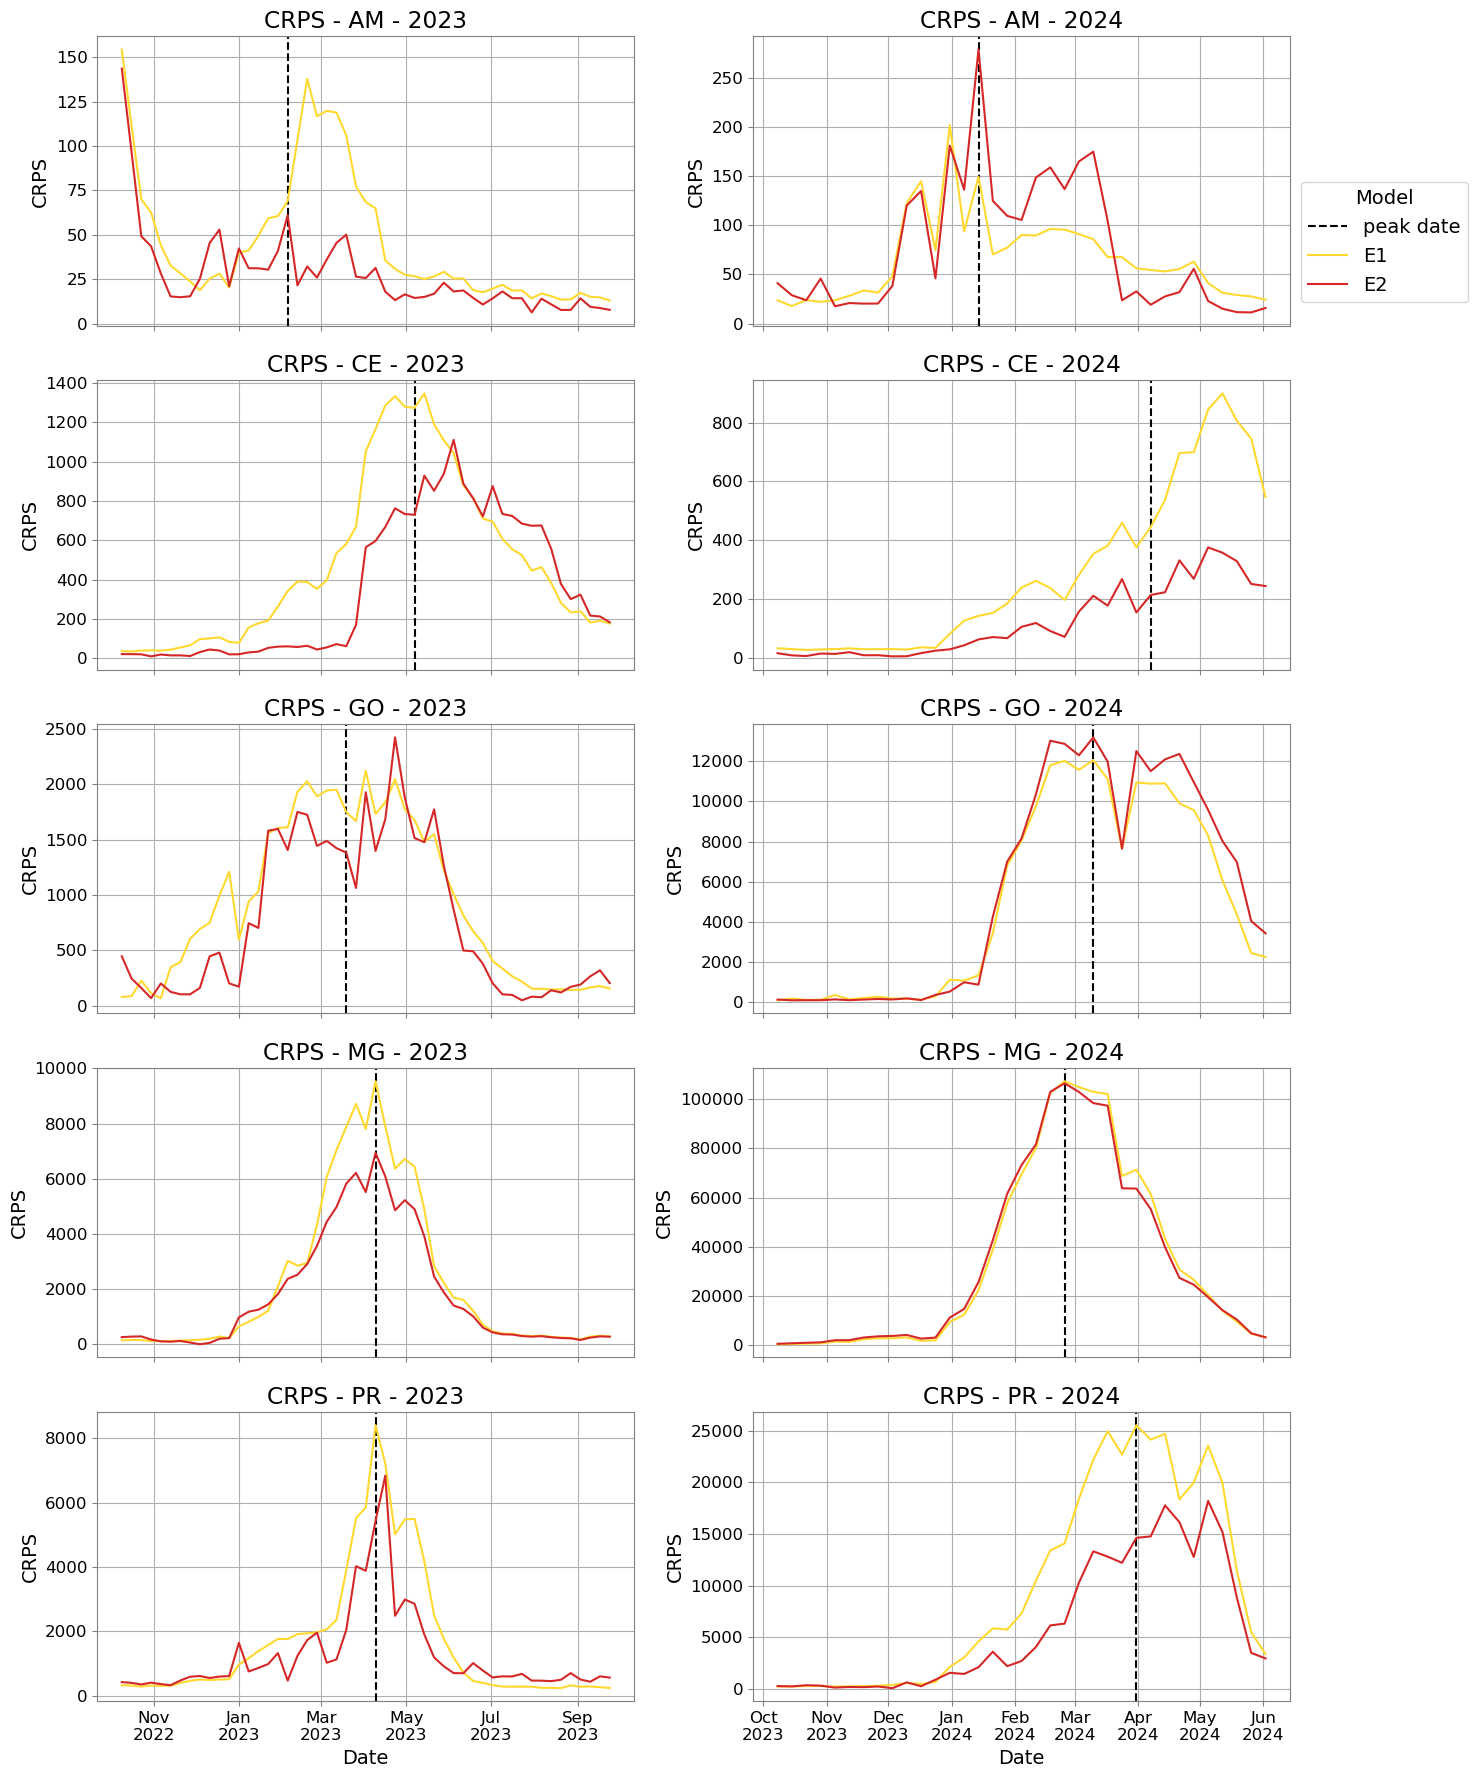

In [22]:
plot_metric_all_state('crps')

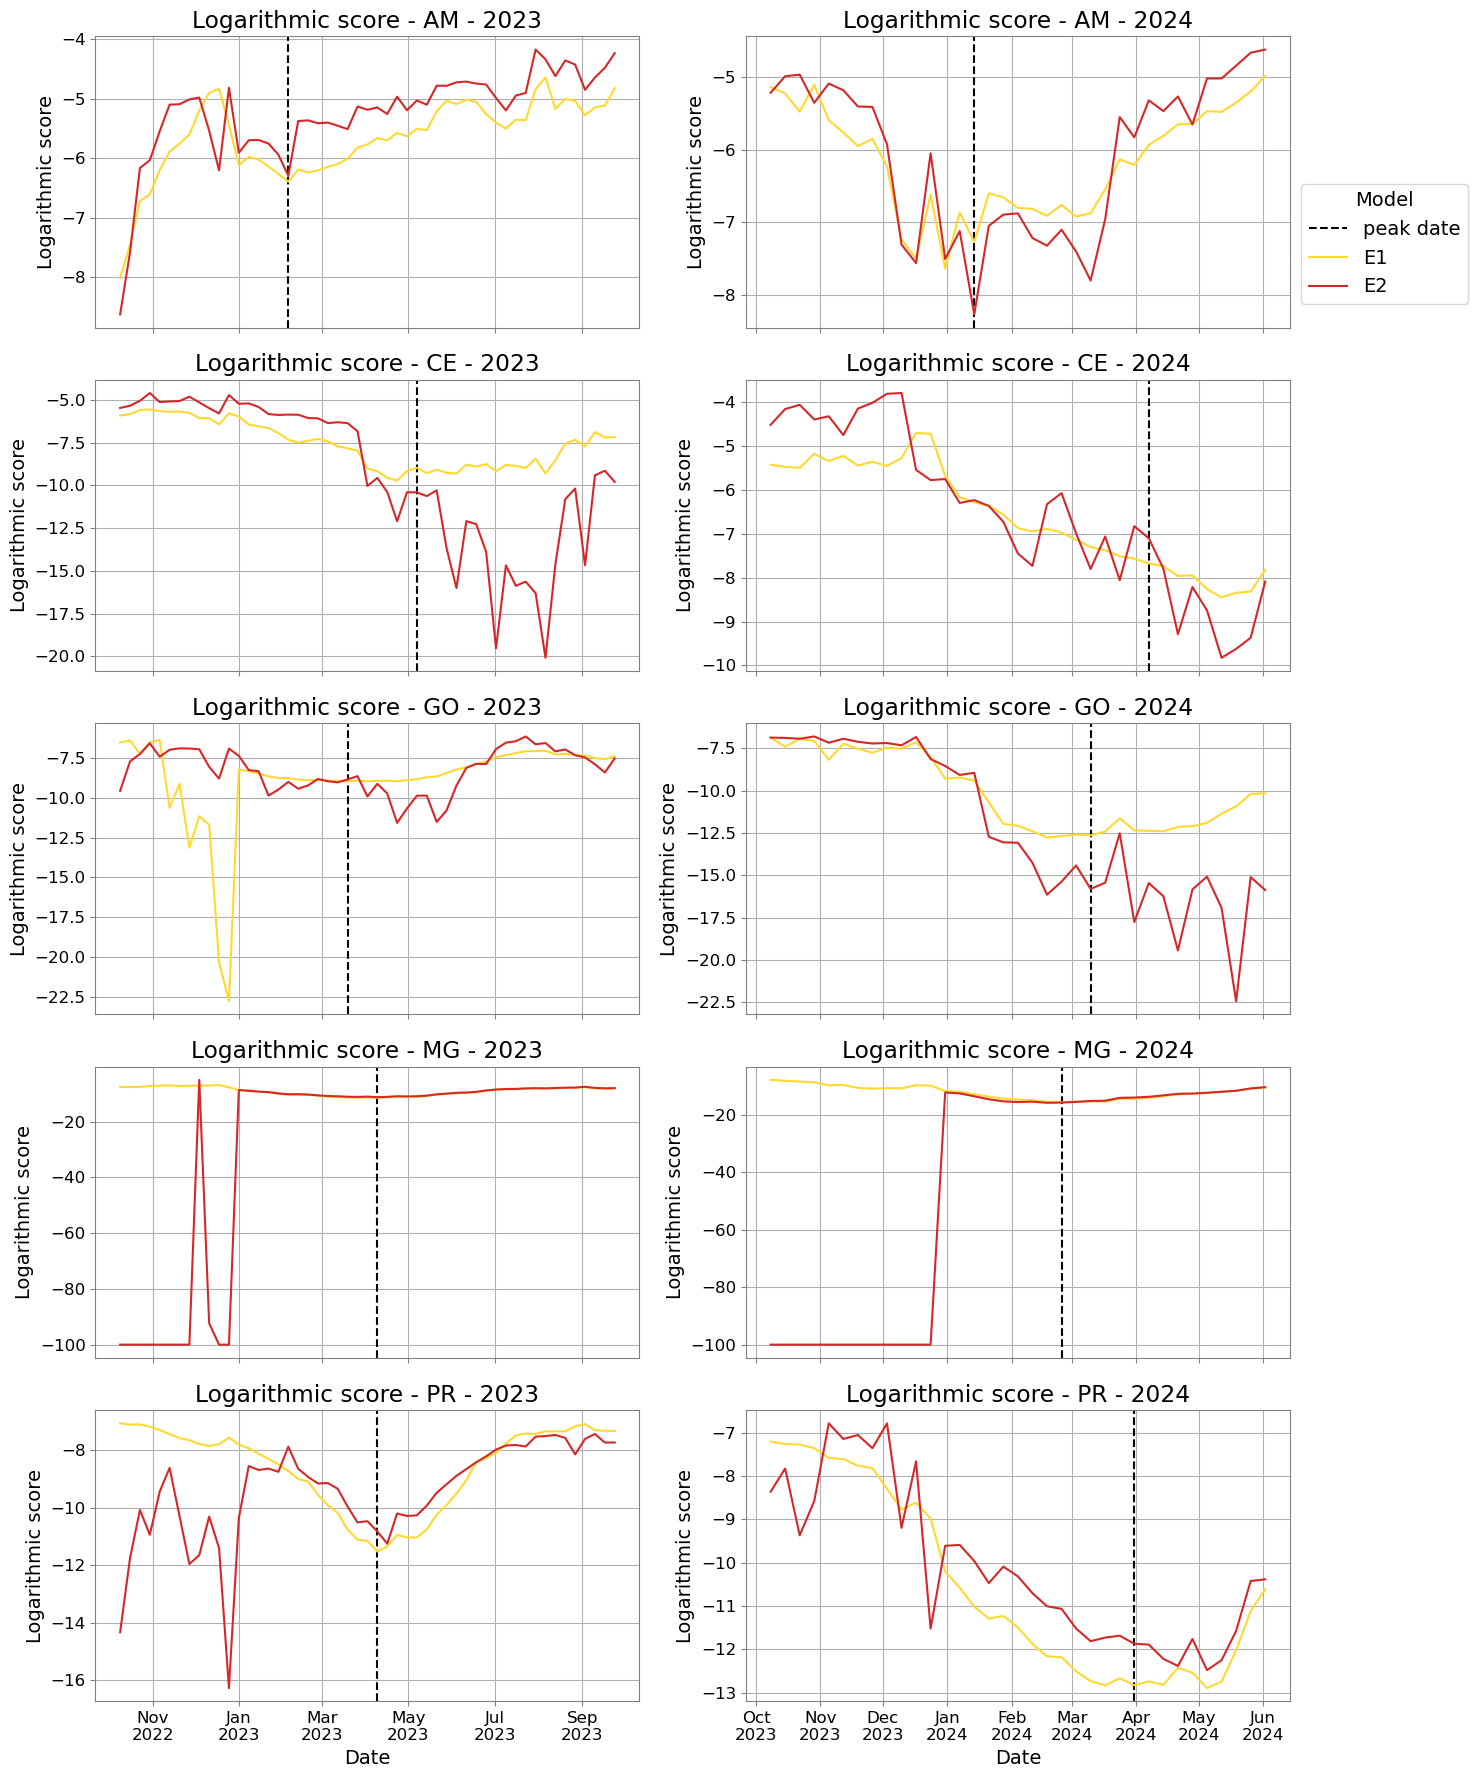

In [23]:
plot_metric_all_state('log_score')

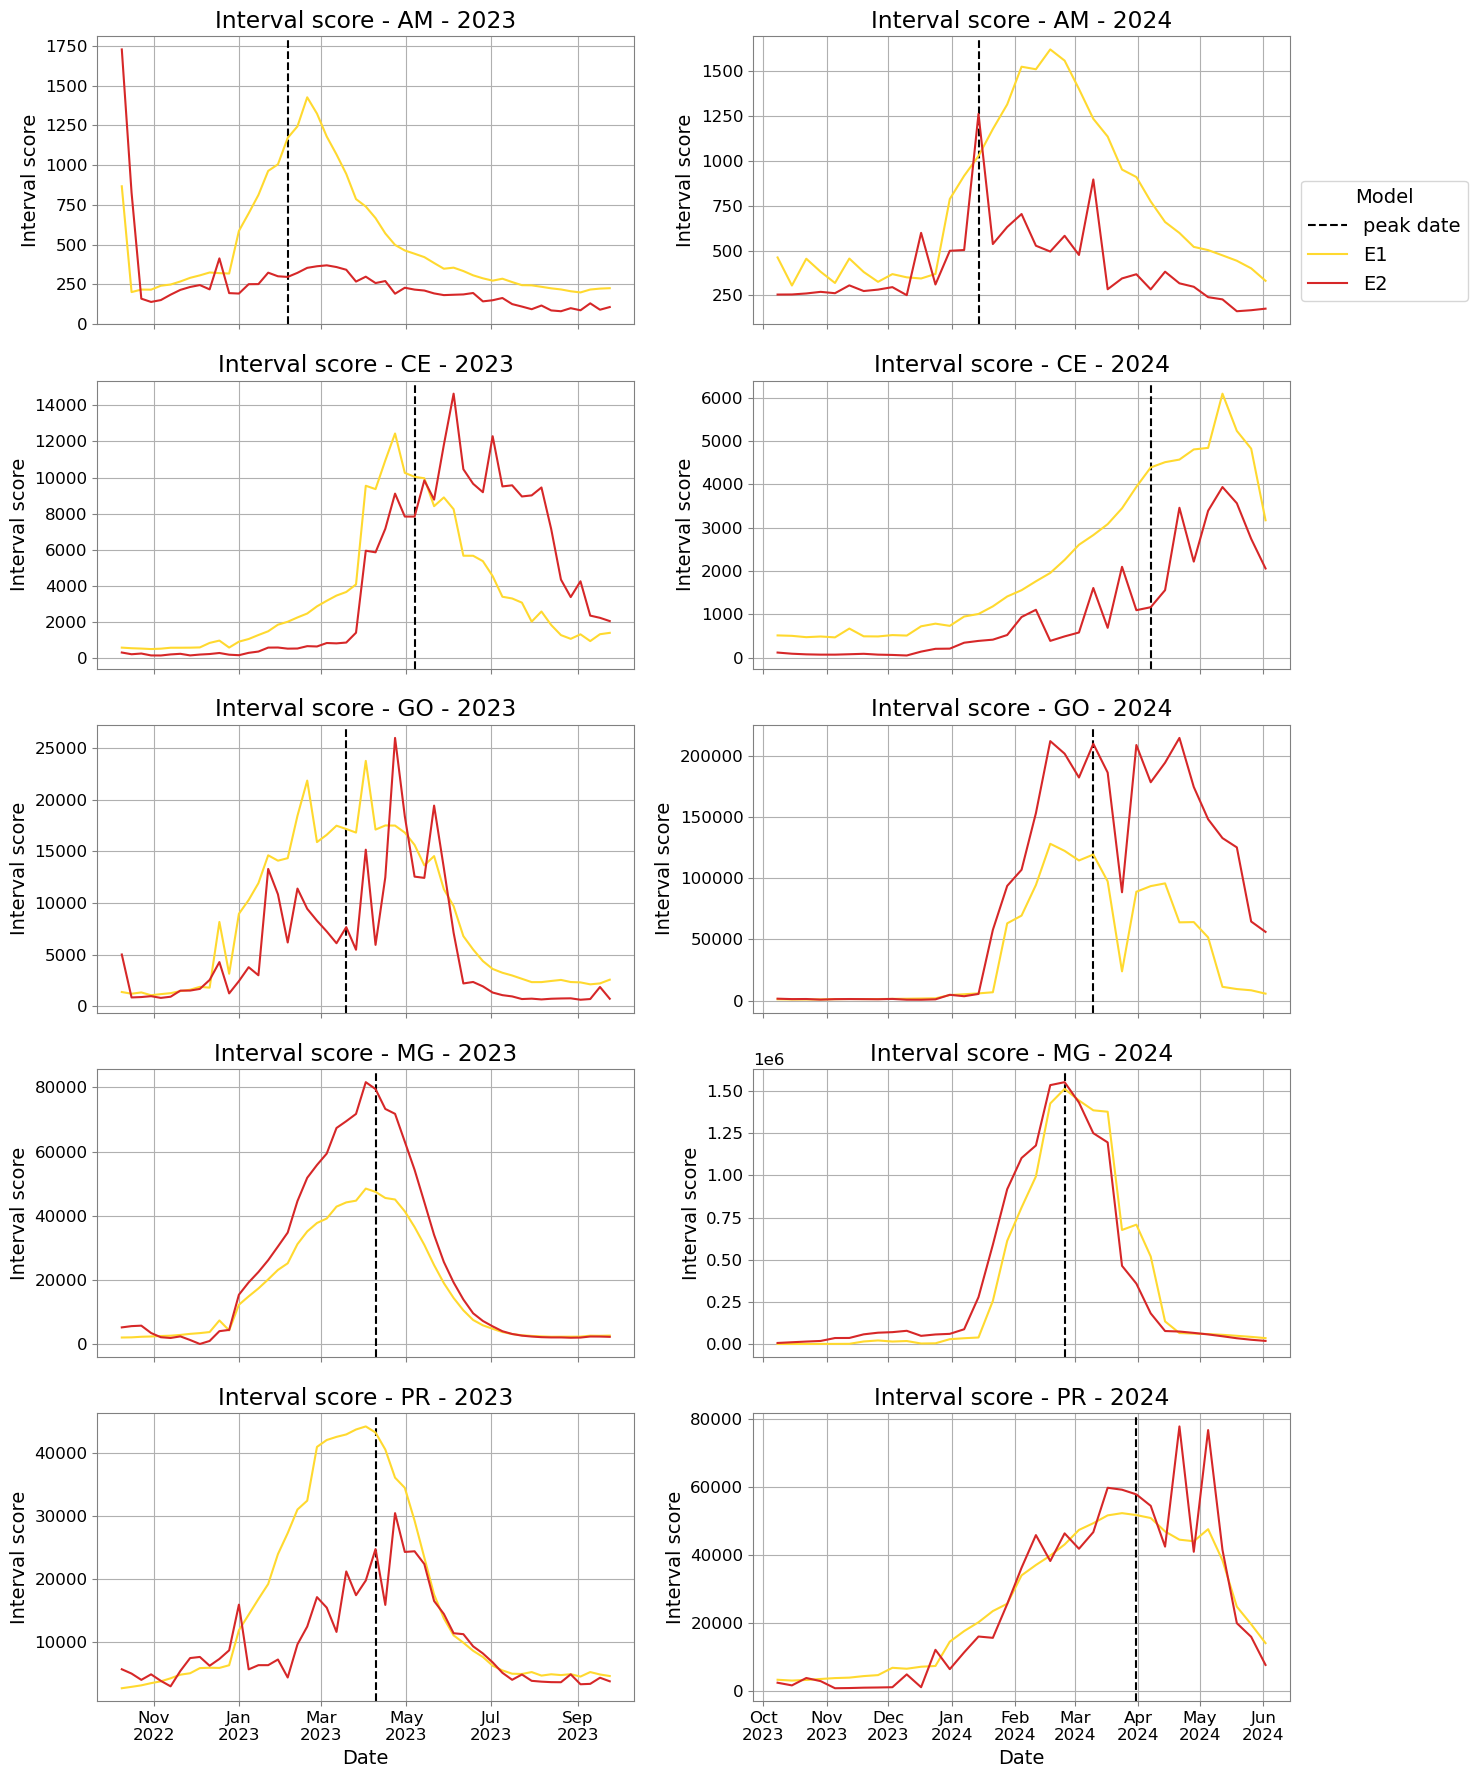

In [24]:
plot_metric_all_state('interval_score')